In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import drive

In [2]:
drive.mount('/content/drive')
PATH= '/content/drive/MyDrive/time series project 1/'
os.chdir(PATH)

Mounted at /content/drive


In [3]:
df = pd.read_csv(PATH + 'AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')
print( df.info() )
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Analysis and stationarization

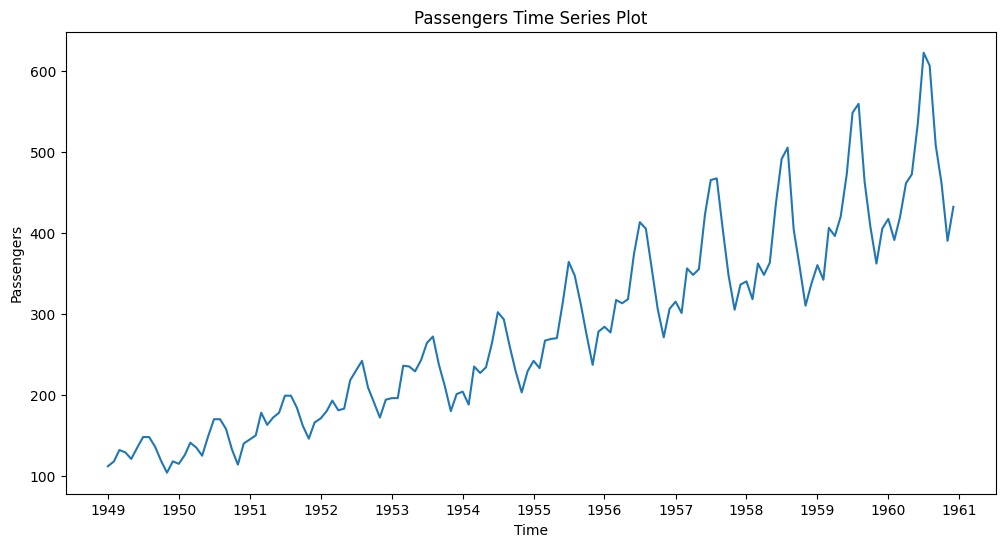

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'])

plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passengers Time Series Plot')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Locate years for ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

plt.show()

from this graph, it is possible to notice that the time series follows a multplicative model and present seasonal components as well, so the next operation will be to compute the logaritm of this series in this way the model become additive and it will be simpler to stationarize

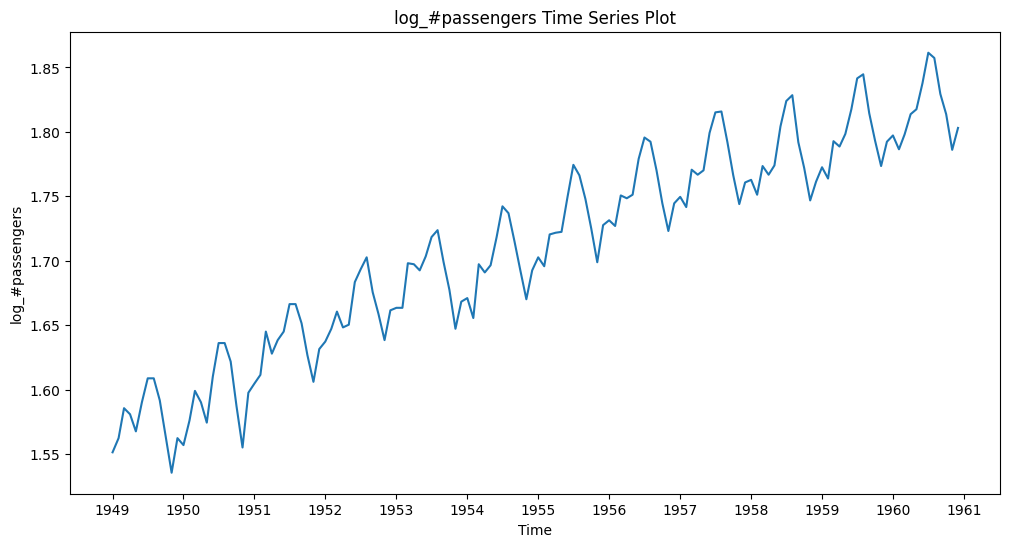

In [5]:
plt.figure(figsize=(12, 6))
df['log_#passengers'] = np.log(df['#Passengers'])
plt.plot(np.log(df['log_#passengers']))

plt.xlabel('Time')
plt.ylabel('log_#passengers')
plt.title('log_#passengers Time Series Plot')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Locate years for ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

plt.show()

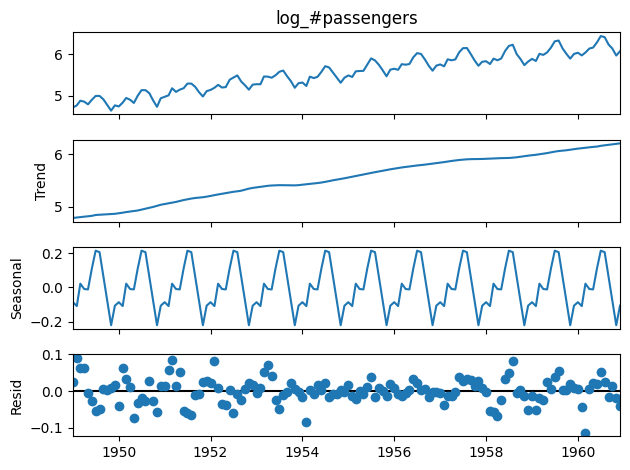

In [6]:
decomposition = seasonal_decompose(df['log_#passengers'], model='additive', period=12, extrapolate_trend='freq')
decomposition.plot()
plt.show()

the decomposition above shows an increasing trend with seasonal component. the next things are to see what happens for ACF and PACF and, in order to stationarize, analyze the detrended series. To do so, it is possible to see what it can be found after a 1st differitiation of the series.

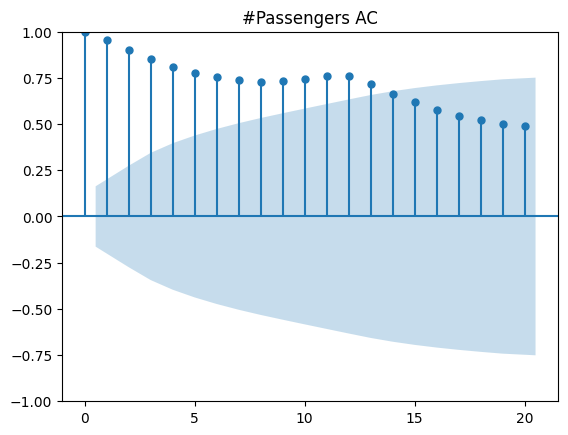

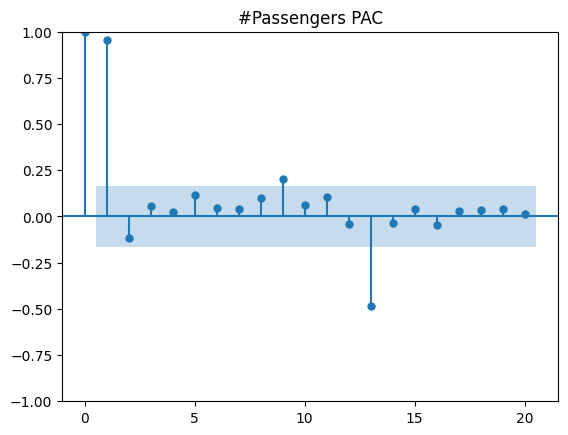

In [7]:
plot_acf(df['log_#passengers'], lags=20, title='#Passengers AC')
plot_pacf(df['log_#passengers'], lags=20, title='#Passengers PAC')
plt.show()

From both ACF and PACF, there is a clear evidence of seasonality at order 12, which means the seasonal component repeats every 12 months and from PACF, it suggests a MA(1) component in the model

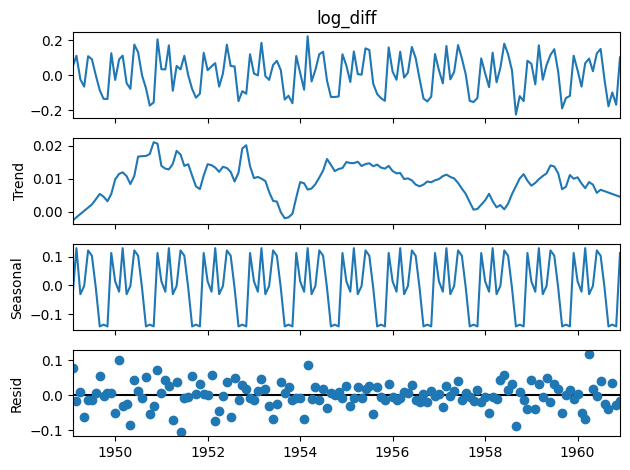

In [8]:
# applying a 1st order differentiation
df['log_diff'] = df['log_#passengers'].diff()

decomposition = seasonal_decompose(df[~df['log_diff'].isna()]['log_diff'], model='additive', period=12, extrapolate_trend='freq')
decomposition.plot()
plt.show()

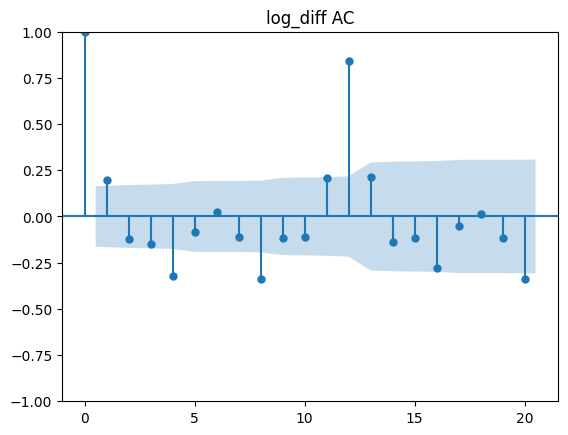

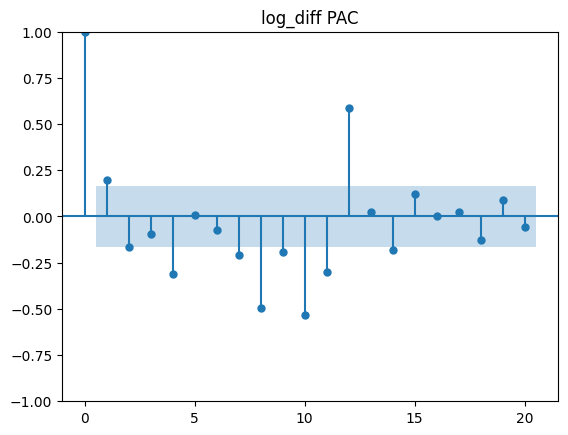

In [9]:
plot_acf(df[~df['log_diff'].isna()]['log_diff'], lags=20, title='log_diff AC')
plot_pacf(df[~df['log_diff'].isna()]['log_diff'], lags=20, title='log_diff PAC')
plt.show()

The ACF and the PACF show a strong correlation at lag 1, 4, 8 and 12

# Modelling

In [10]:
s_model = SARIMAX(df[~df['log_diff'].isna()]['log_diff'], order=(1,0,1), seasonal_order=(1,0,1,12))
model_fit = s_model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           log_diff   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 254.501
Date:                            Fri, 24 Jan 2025   AIC                           -499.002
Time:                                    15:10:25   BIC                           -484.187
Sample:                                02-01-1949   HQIC                          -492.982
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4056      0.167      2.424      0.015       0.078       0.734
ma.L1         -0.7253      0.134   

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


the results of the model are quite significant, with no heteroskedasticity of the errors, and from the p-values of the coefficients and their standard error, there is a strong evidence that the number of parameters of the model and their value does not dependes by random chance.

The next analysis will focus on the residual and see wheather there is other components or it is simply white noise

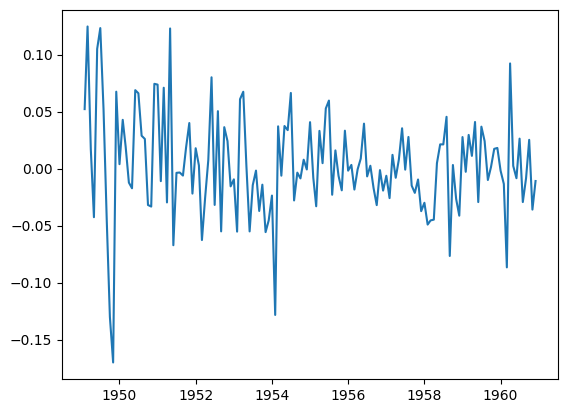

In [11]:
plt.plot(model_fit.resid)

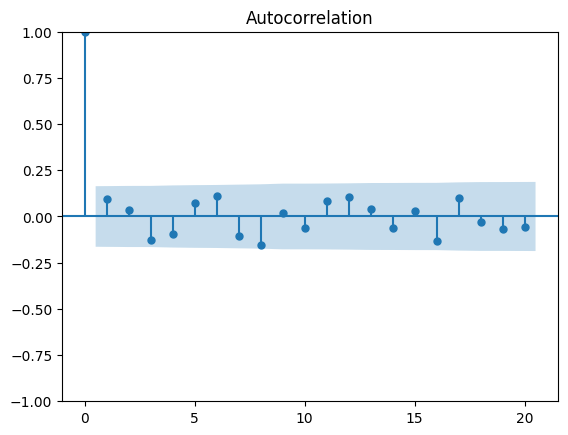

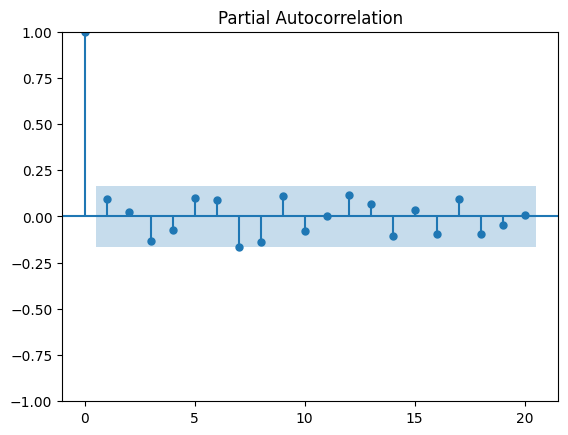

In [12]:
plot_acf(model_fit.resid, lags=20)
plot_pacf(model_fit.resid, lags=20)
plt.show()

From the ACF and PACF of the residual, there is not any significant lag, and so no correlation which leads to recognize this as white noise, which means there are no more component in the series.

# Forecasting analysis of the model (refactor wip)

## Cross-Validation

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fold: 1


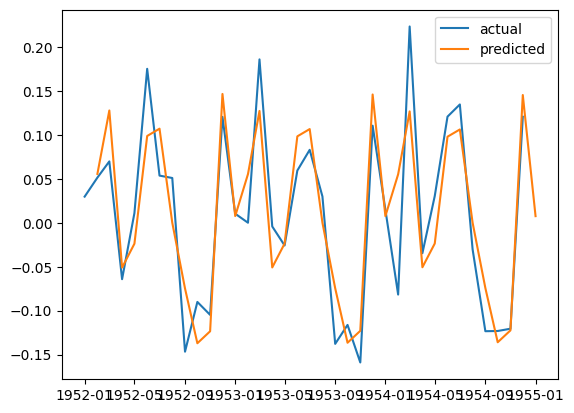

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fold: 2


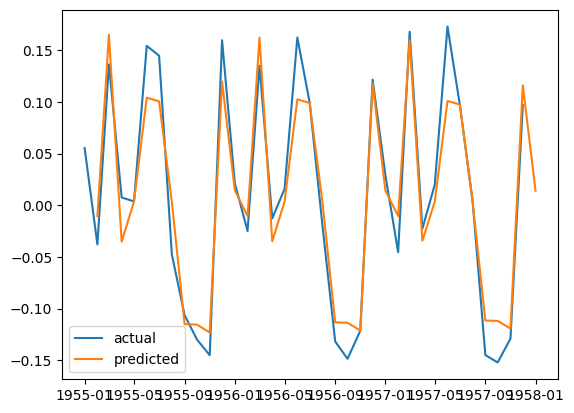

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


fold: 3


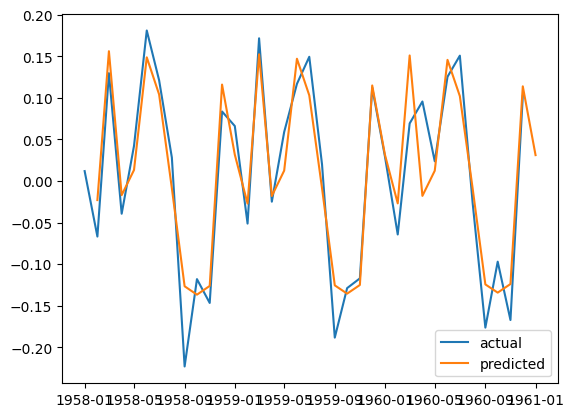

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse, rmse = list(), list()
cv = TimeSeriesSplit(n_splits=3)
fold = 1
for train_index, test_index in cv.split(df):

    x_train, x_test = df.iloc[train_index], df.iloc[test_index]
    model = SARIMAX(x_train['log_diff'][1:], order=(1,0,1), seasonal_order=(1,0,1,12))
    model_fit = model.fit()
    y_pred = model_fit.predict(start = len(x_train), end= len(x_train) + len(x_test) -1 )
    mse.append( mean_squared_error(x_test['log_diff'], y_pred) )
    rmse.append( np.sqrt(mean_squared_error(x_test['log_diff'], y_pred)))


    print(f'fold: {fold}')
    plt.plot(x_test['log_diff'])
    plt.plot(y_pred)
    plt.legend(['actual', 'predicted'])
    plt.show()
    fold += 1

In [14]:
print('average of mean squared errors (MSE]): ', sum(mse)/len(mse))
print('average of root mean squared errors (RMSE): ', sum(rmse)/len(rmse))

average of mean squared errors (MSE]):  0.016179982275495882
average of root mean squared errors (RMSE):  0.1271688322547517


## Forecasting

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-15-0f43a2270f91>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasting[0] += df['log_#passengers'].iloc[-1]
<ipython-input-15-0f43a2270f91>:5: FutureWarning: Seri

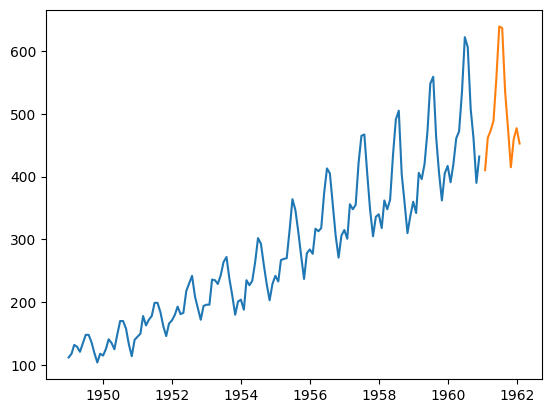

In [15]:
model = SARIMAX(df['log_diff'][1:], order=(1,0,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()
forecasting = model_fit.predict(start = len(df), end= len(df) + 12)

forecasting[0] += df['log_#passengers'].iloc[-1]
forecasting = np.exp(forecasting.cumsum())
plt.plot(df['#Passengers'])
plt.plot(forecasting)
plt.show()